# Basics of Pytorch for Computer Vision
Training classifier on CIFAR dataset.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
from tqdm.notebook import tqdm, trange
from typing import List
from collections import Counter

---
#### Dealing with data using torch utilities

In [2]:
def flatten(x):
    return x.view(-1)

transform = transforms.Compose(
    [transforms.ToTensor(), flatten])

# Built-in dataset (the same as Kaggle)
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_size = int(0.8 * len(dataset))  # 40_000
test_size = len(dataset) - train_size  # 10_000
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Used to iterate over data with batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


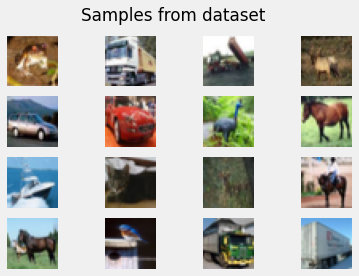

In [3]:
def imshow(tensor, ax=None):
    # permuting, because we want rgb channels as third dimension (not first)
    image = tensor.view(3, 32, 32)
    image = image.permute(1, 2, 0)
    if ax:
        ax.imshow(image)
    else:
        plt.imshow(image)
        plt.show()

size = 4
fig, axes = plt.subplots(size, size)
for i in range(0, size):
    for j in range(0, size):
        imshow(dataset[i*size + j][0], axes[i][j])
        axes[i][j].axis("off")
fig.suptitle("Samples from dataset");

---

#### Defining a model
Subclassing nn.Module.

In [4]:
INPUT_DIM = 3072  # 3 * 32 * 32
OUTPUT_DIM = len(classes)

class LinearRelu(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRelu, self).__init__()
        self.layer = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        z = self.layer(x)
        return self.activation(z)
        

class Feedforward(nn.Module):
    def __init__(self, hidden_sizes: List[int]):
        super(Feedforward, self).__init__()
        n_hidden_layers = len(hidden_sizes)
        layers = [LinearRelu(hidden_sizes[i], hidden_sizes[i+1]) for i in range(n_hidden_layers - 1)]
        if hidden_sizes:
            self.model = torch.nn.Sequential(
                LinearRelu(INPUT_DIM, hidden_sizes[0]),
                *layers,
                nn.Linear(hidden_sizes[-1], OUTPUT_DIM)
            )
        else:
            self.model = nn.Linear(INPUT_DIM, OUTPUT_DIM)
    
    def forward(self, x):
        return self.model(x)

---
#### Training

In [5]:
# Intitializing SummaryWriter for tensorboard
writer = SummaryWriter('runs/cifar')  # to disable warnings make sure you have numpy==1.16.4 installed (not 1.17 or 1.18)

hidden_sizes = [512]
lr = 0.001

# Intializing model, criterion and optimizer
# (CrossEntropyLoss combines Softmax with MutlinomialLoss, that's why we didn't use softmax in a Feedforward model)
net = Feedforward([512])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

hyperparameters = dict(
    model_type = "feedforward",
    lr = lr,
    hidden_sizes = str(hidden_sizes)
)

In [7]:
n_epochs = 1  # one epoch takes a few (~3) minutes on CPU with one hidden layer model

# Training loop
running_loss = 0.0
for epoch in range(n_epochs):  # loop over the dataset multiple times

    for i, data in enumerate(tqdm(trainloader, leave=False), 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            running_loss = 0.0
    # Saving model parameters
    torch.save(net.state_dict(), "states/epoch{}".format(epoch))
print('Finished Training')

Finished Training


In [8]:
writer.add_graph(net, inputs)
writer.add_hparams({"model_type": "feedforward", "hidden_sizes": str([512])}, {})

---
#### Evaluating model

In [16]:
def get_accuracy_and_predictions(data):
    predictions = []
    n = len(data)
    correct = 0
    for tensor, label in tqdm(data, leave=False):
        logits = net(tensor)
        y_pred = logits.argmax().item()
        predictions.append(y_pred)
        if (y_pred == label):
            correct += 1
    return correct / n, predictions

In [17]:
acc, preds = get_accuracy_and_predictions(testset)
acc, Counter(preds)

(0.3476,
 Counter({4: 1417,
          0: 659,
          2: 645,
          7: 2038,
          1: 915,
          5: 954,
          8: 1068,
          9: 689,
          3: 1030,
          6: 585}))

In [18]:
acc, _ = get_accuracy_and_predictions(trainset)
acc

0.356025